In [1]:
import math
import random
import pickle
import itertools

import numpy as np 
import pandas as pd 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import label_ranking_average_precision_score, label_ranking_loss, coverage_error 
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle

from scipy.signal import resample

import matplotlib.pyplot as plt

np.random.seed(42)

import pickle


from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation# , Dropout
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

Using TensorFlow backend.


In [2]:
df = pd.read_csv("D:/cao/kaggle/ECG/mitbih_train.csv", header=None)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df2 = pd.read_csv("D:/cao/kaggle/ECG/mitbih_test.csv", header=None)

In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


In [7]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
# 训练集和测试集合并在一张表里

df = pd.concat([df, df2], axis=0)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109446 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 157.8 MB


In [10]:
# 查看 5 个类的样本数

df[187].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: 187, dtype: int64

In [11]:
M = df.values
X = M[:, :-1]
y = M[:, -1].astype(int)

In [12]:
X.shape

(109446, 187)

In [13]:
y.shape

(109446,)

In [14]:
# 删除不再使用的变量

del df
del df2
del M

### 数据展示

In [15]:
# 绘制 5 种不同类别的心电图

C0 = np.argwhere(y == 0).flatten()
C1 = np.argwhere(y == 1).flatten()
C2 = np.argwhere(y == 2).flatten()
C3 = np.argwhere(y == 3).flatten()
C4 = np.argwhere(y == 4).flatten()

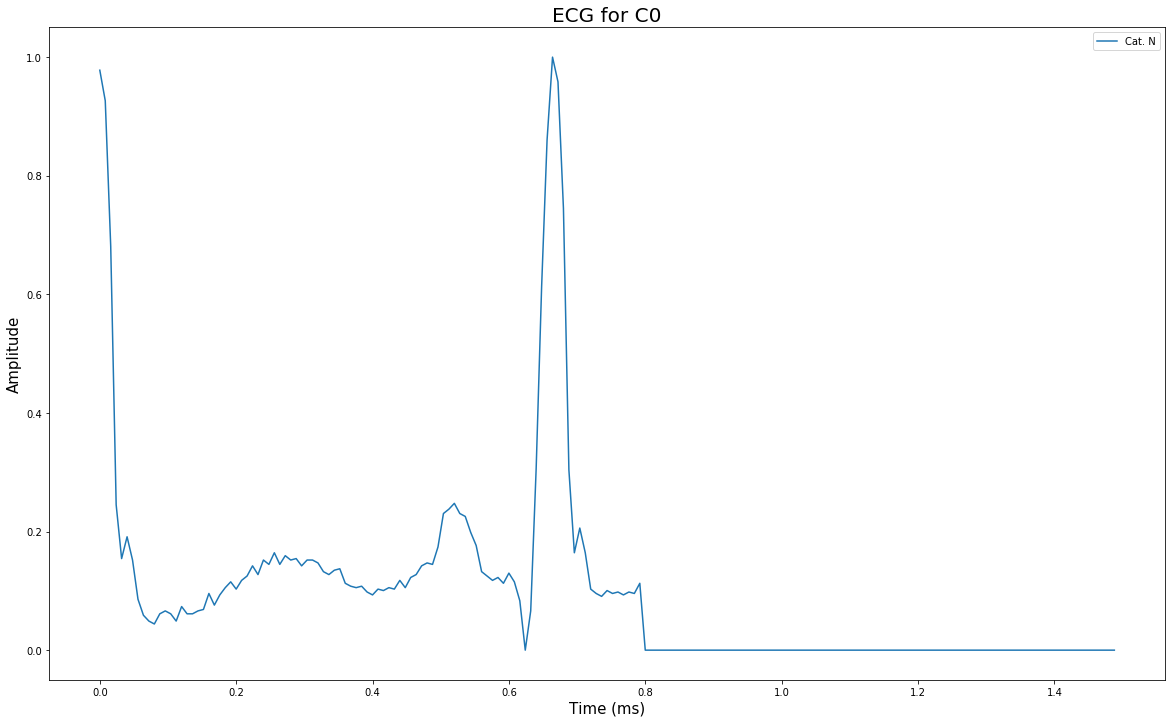

In [16]:
# 取每个类别的其中一组数据来展示

# 限定 x 的范围，即限定时间的范围
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label='Cat. N')
#plt.plot(x, X[C1, :][0], label='Cat. S')
#plt.plot(x, X[C2, :][0], label='Cat. V')
#plt.plot(x, X[C3, :][0], label='Cat. F')
#plt.plot(x, X[C4, :][0], label='Cat. Q')
plt.legend()
plt.title("ECG for C0", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

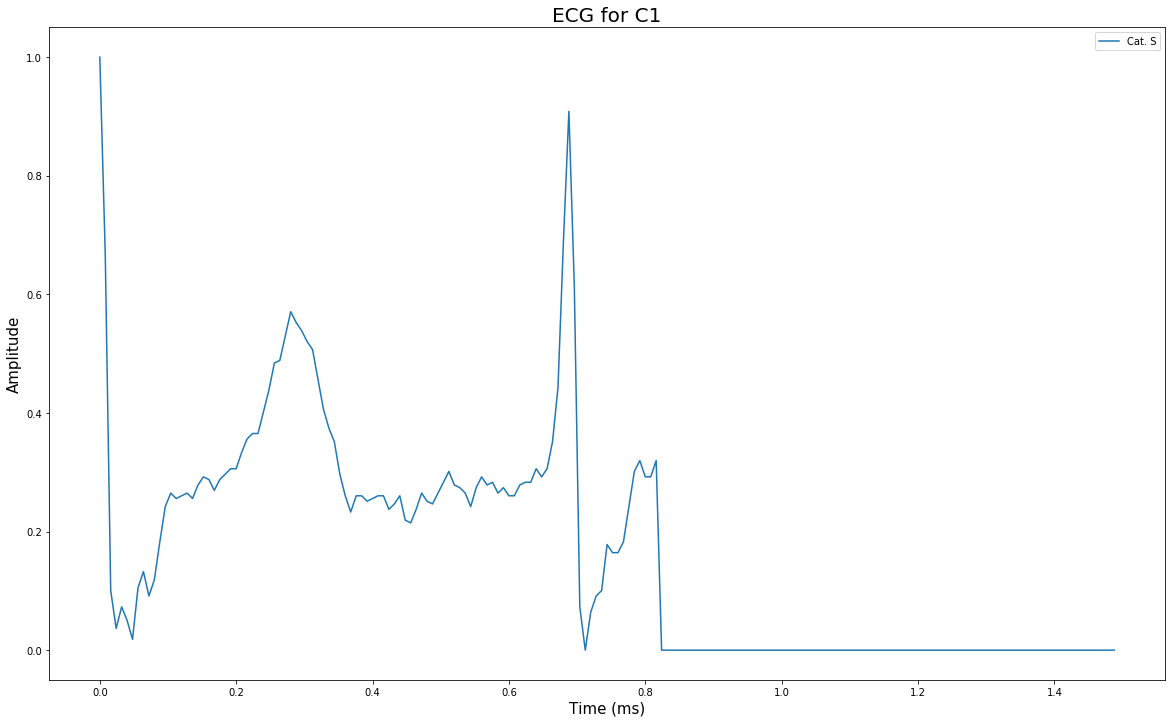

In [17]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
#plt.plot(x, X[C0, :][0], label='Cat. N')
plt.plot(x, X[C1, :][0], label='Cat. S')
#plt.plot(x, X[C2, :][0], label='Cat. V')
#plt.plot(x, X[C3, :][0], label='Cat. F')
#plt.plot(x, X[C4, :][0], label='Cat. Q')
plt.legend()
plt.title("ECG for C1", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

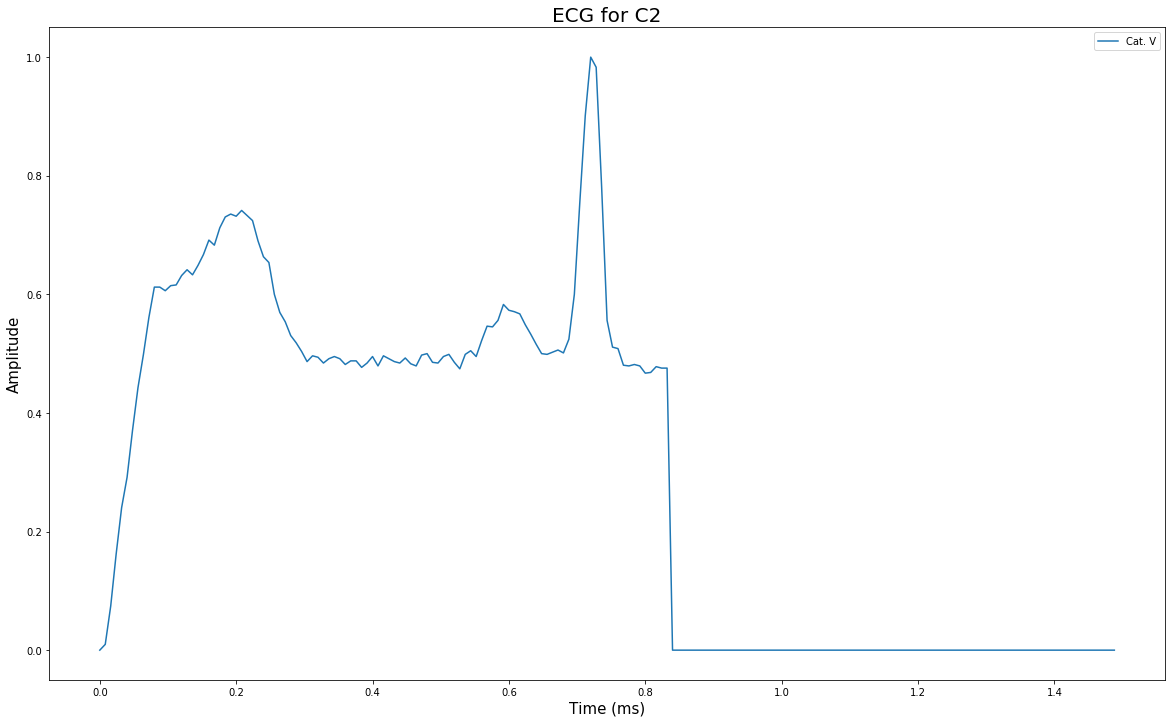

In [18]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
#plt.plot(x, X[C0, :][0], label='Cat. N')
#plt.plot(x, X[C1, :][0], label='Cat. S')
plt.plot(x, X[C2, :][0], label='Cat. V')
#plt.plot(x, X[C3, :][0], label='Cat. F')
#plt.plot(x, X[C4, :][0], label='Cat. Q')
plt.legend()
plt.title("ECG for C2", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

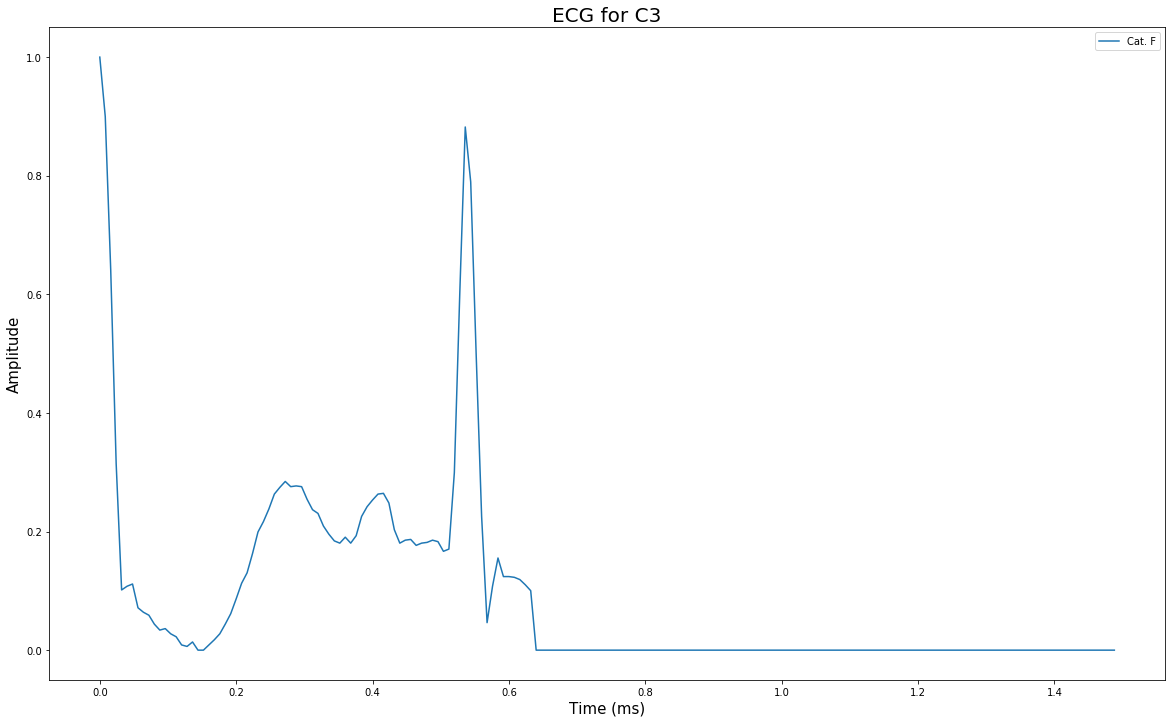

In [19]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
#plt.plot(x, X[C0, :][0], label='Cat. N')
#plt.plot(x, X[C1, :][0], label='Cat. S')
#plt.plot(x, X[C2, :][0], label='Cat. V')
plt.plot(x, X[C3, :][0], label='Cat. F')
#plt.plot(x, X[C4, :][0], label='Cat. Q')
plt.legend()
plt.title("ECG for C3", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

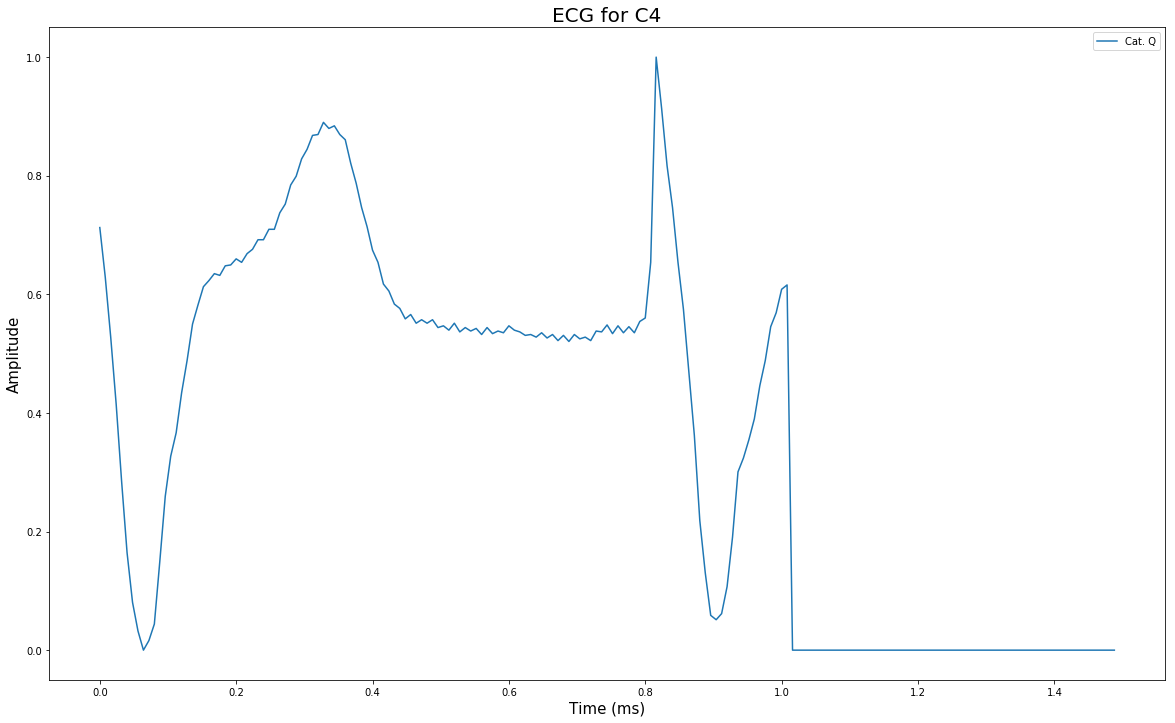

In [20]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
#plt.plot(x, X[C0, :][0], label='Cat. N')
#plt.plot(x, X[C1, :][0], label='Cat. S')
#plt.plot(x, X[C2, :][0], label='Cat. V')
#plt.plot(x, X[C3, :][0], label='Cat. F')
plt.plot(x, X[C4, :][0], label='Cat. Q')
plt.legend()
plt.title("ECG for C4", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

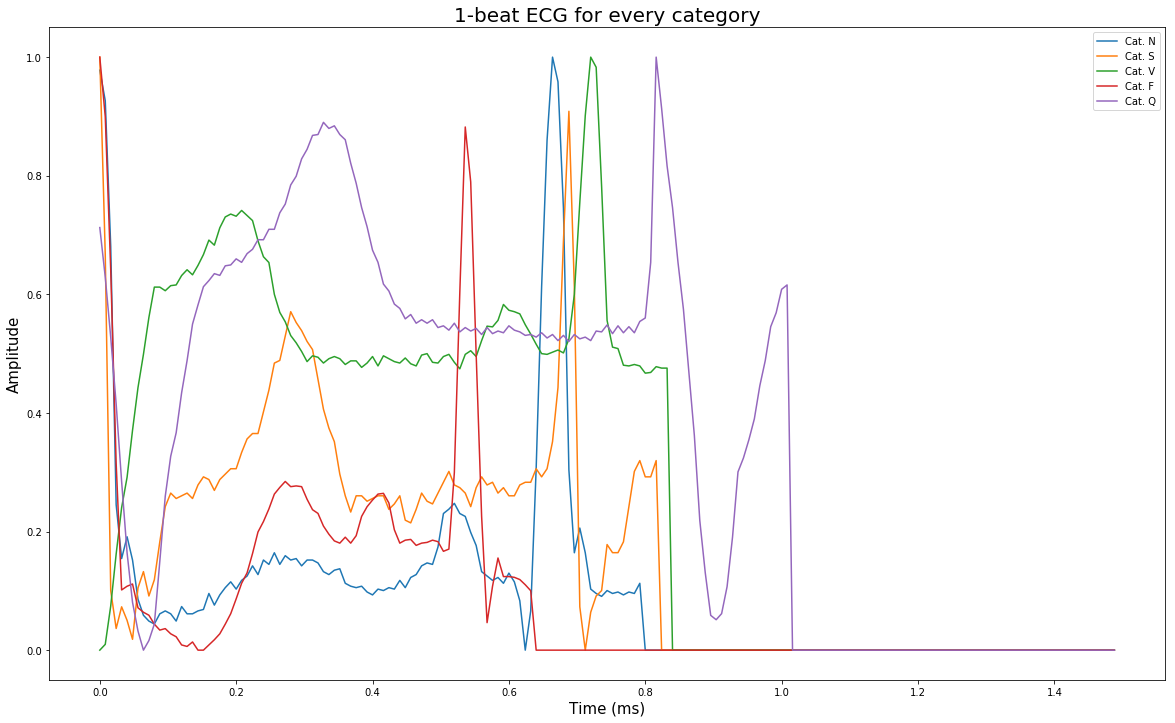

In [21]:
x = np.arange(0, 187)*8/1000

plt.figure(figsize=(20,12))
plt.plot(x, X[C0, :][0], label='Cat. N')
plt.plot(x, X[C1, :][0], label='Cat. S')
plt.plot(x, X[C2, :][0], label='Cat. V')
plt.plot(x, X[C3, :][0], label='Cat. F')
plt.plot(x, X[C4, :][0], label='Cat. Q')
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

### 数据增强

为了使所有类别的数据都处于相同的水平，所以需要进行数据增强处理。然而，这里只是将最少的类（第 3 类）增加到与类别 1 相同的级别。由此我们将能够具有大约 5x800 观测值的测试集。

In [22]:
# 伸展
def stretch(x):
    # 将 187 的长度随机重新采样
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    # 长度小于 187 的填充 0
    if l < 187:
        y_ = np.zeros(shape=(187,))
        y_[:l] = y
    # 长度大于 187 的裁剪到 187 的长度
    else:
        y_ = y[:187]
    return y_

<function matplotlib.pyplot.show(*args, **kw)>

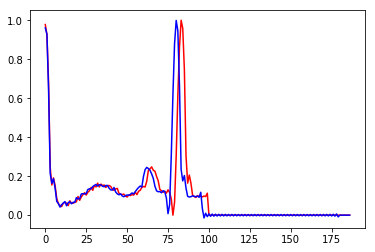

In [24]:
plt.plot(X[0, :], 'r') # X[0, :] == X[0]
plt.plot(stretch(X[0, :]), 'b')
plt.show

In [25]:
# 放大
def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha) # 放大的幅度几乎很小
    return x*factor

<function matplotlib.pyplot.show(*args, **kw)>

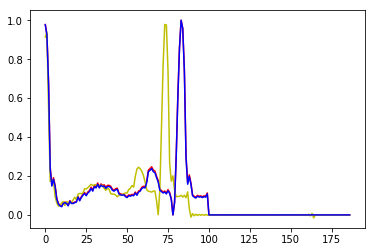

In [26]:
plt.plot(X[0, :], 'r') # X[0, :] == X[0]
plt.plot(stretch(X[0, :]), 'y')
plt.plot(amplify(X[0, :]), 'b')
plt.show

In [27]:
def augment(x):
    
    result = np.zeros(shape=(4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_y = stretch(x)
        elif random.random() < 0.66:
            new_y = amplify(x)
        else:
            new_y = stretch(x)
            new_y = amplify(new_y)
        result[i, :] = new_y
        
    return result

In [28]:
print("examples for C0: ", X[C0, :].shape[0])
print("examples for C1: ", X[C1, :].shape[0])
print("examples for C2: ", X[C2, :].shape[0])
print("examples for C3: ", X[C3, :].shape[0])
print("examples for C4: ", X[C4, :].shape[0])

examples for C0:  90589
examples for C1:  2779
examples for C2:  7236
examples for C3:  803
examples for C4:  8039


In [30]:
# 将 augment 这个函数按照所设定的 axis 应用
result = np.apply_along_axis(augment, axis=1, arr=X[C3]).reshape(-1, 187)

# 将 C3 的数据增强到与其他一样的级别
classes = np.ones(shape=(result.shape[0],),dtype=int)*3

# 按垂直方向堆叠扩增的数据
X = np.vstack([X, result]) 
y = np.hstack([y, classes])

### 划分数据集

In [31]:
# 随机从各个类别中抽取 800 个索引，用于后面建立测试集

subC0 = np.random.choice(C0, 800)
subC1 = np.random.choice(C1, 800)
subC2 = np.random.choice(C2, 800)
subC3 = np.random.choice(C3, 800)
subC4 = np.random.choice(C4, 800)

In [32]:
X_test = np.vstack([X[subC0], X[subC1], X[subC2], X[subC3], X[subC4]])
y_test = np.hstack([y[subC0], y[subC1], y[subC2], y[subC3], y[subC4]])
print("test set shape: ", X_test.shape)
print("test examples: ", X_test.shape[0])

test set shape:  (4000, 187)
test examples:  4000


In [33]:
# 除去测试集的数据，剩下的都是训练集

X_train = np.delete(X, [subC0, subC1, subC2, subC3, subC4], axis=0)
y_train = np.delete(y, [subC0, subC1, subC2, subC3, subC4], axis=0)
print("train examples: ", y_train.shape[0])

train examples:  112362


In [34]:
X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_test, y_test = shuffle(X_test, y_test, random_state=0)

In [35]:
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)

print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (112362, 187, 1)
y_train (112362,)
X_test (4000, 187, 1)
y_test (4000,)


In [36]:
# 转换为 one-hot 向量

ohe = OneHotEncoder()
y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))

d:\anaconda3\envs\python36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [37]:
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

X_train (112362, 187, 1)
y_train (112362, 5)
X_test (4000, 187, 1)
y_test (4000, 5)


### 模型

![论文提出的模型结构](https://ai2-s2-public.s3-us-west-2.amazonaws.com/figures/2017-08-08/0efe20fd1dc65030fa57f7c0727f13b93d51adce/1-Figure1-1.png)

In [38]:
n_obs, feature, depth = X_train.shape
batch_size = 512

In [39]:
K.clear_session()

# Input
inp = Input(shape=(feature, depth))
# Conv
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

# 【1】
# Conv
C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
# ReLU
A11 = Activation("relu")(C11)
# Conv
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
# Shortcut
S11 = Add()([C12, C]) 
# ReLU
A12 = Activation("relu")(S11)
# Pool
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)

#【2】
# Conv
C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
# ReLU
A21 = Activation("relu")(C21)
# Conv
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
# Shortcut
S21 = Add()([C22, M11])
# ReLU
A22 = Activation("relu")(S11)
# Pool
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


# 【3】
# Conv
C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
# ReLU
A31 = Activation("relu")(C31)
# Conv
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
# Shortcut
S31 = Add()([C32, M21])
# ReLU
A32 = Activation("relu")(S31)
# Pool
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)

# 【4】
# Conv
C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
# ReLU
A41 = Activation("relu")(C41)
# Conv
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
# Shortcut
S41 = Add()([C42, M31])
# ReLU
A42 = Activation("relu")(S41)
# Pool
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

# 【5】
# Conv
C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
# ReLU
A51 = Activation("relu")(C51)
# Conv
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
# Shortcut
S51 = Add()([C52, M41])
# ReLU
A52 = Activation("relu")(S51)
# Pool
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

# FC
D1 = Dense(32)(F1)
# ReLU
A6 = Activation("relu")(D1)
# FC
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
# Softmax
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 187, 1)       0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 183, 32)      5152        conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 183, 32)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (

In [40]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [41]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

In [42]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

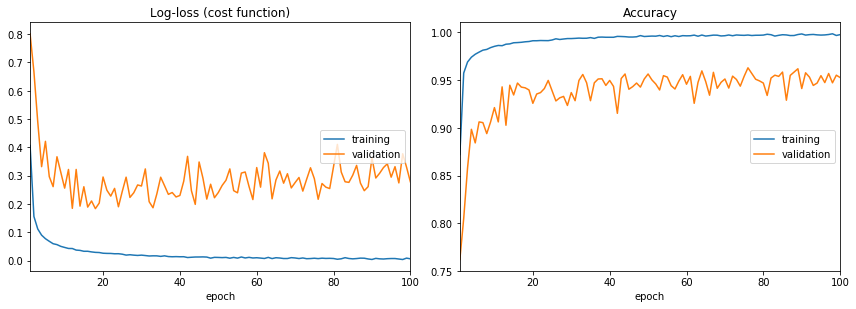

Log-loss (cost function):
training   (min:    0.004, max:    0.407, cur:    0.007)
validation (min:    0.184, max:    0.801, cur:    0.279)

Accuracy:
training   (min:    0.872, max:    0.999, cur:    0.998)
validation (min:    0.762, max:    0.963, cur:    0.953)


In [43]:
from livelossplot import PlotLossesKeras

history = model.fit(X_train, y_train, 
                    epochs=100, 
                    batch_size=batch_size, 
                    verbose=1, 
                    validation_data=(X_test, y_test), 
                    callbacks=[PlotLossesKeras()]) # callbacks=[exp_decay]

In [44]:
y_pred = model.predict(X_test, batch_size=1000)

In [45]:
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.91       800
           1       0.99      0.87      0.93       800
           2       0.99      0.94      0.96       800
           3       0.99      0.97      0.98       800
           4       1.00      0.99      0.99       800

   micro avg       0.95      0.95      0.95      4000
   macro avg       0.96      0.95      0.95      4000
weighted avg       0.96      0.95      0.95      4000



In [46]:
print("ranking-based average precision: {:.3f}".format(label_ranking_average_precision_score(y_test.todense(), y_pred)))
print("Rnaking loss: {:.3f}".format(label_ranking_loss(y_test.todense(), y_pred)))
print("Coverge_error: {:.3f}".format(coverage_error(y_test.todense(), y_pred)))

ranking-based average precision: 0.975
Rnaking loss: 0.014
Coverge_error: 1.057


Confusion matrix, without normalization


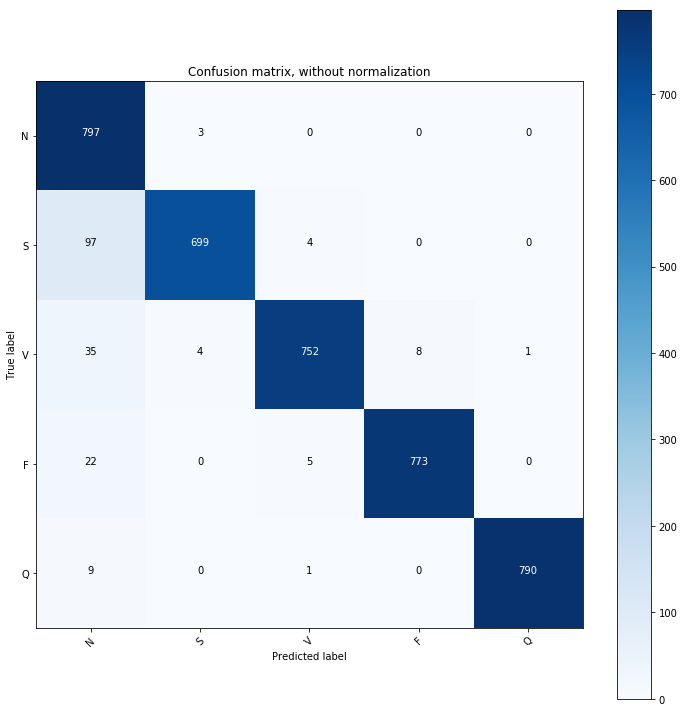

In [47]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=['N', 'S', 'V', 'F', 'Q'],
                      title='Confusion matrix, without normalization')
plt.show()